# Cart Pole Experimentation

Cart Pole is an environment provided by OpenAI gym. This is a really basic Reinforcement Learning (RL) environment - I recently saw it described as the "Hello World" of RL. The environment considers a pole on a cart, and the cart can either move left or right in order to keep the pole upright. If the pole falls beyond a certain angle, or the cart moves outside certain bounds, the episode terminates. 

The state is defined by the observation - this has cart position, cart velocity, pole angle, and pole
angular velocity in that order (these numbers are the output from env.reset()). env.step(action = 0 or 1) gives us observation, reward, done, info, in that order. The reward is +1 for every additional step, including the termination step. More information on the environment can be found here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

In this notebook, I want to build and train a RL agent to solve this environment successfully using a DDQN algorithm.

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import gymnasium as gym
from IPython import display
plt.rcParams['figure.dpi'] = 150

### Agent Class

In [20]:
class DQNAgent():
    """
    RL agent that utilizes a DQN algorithm to solve the Cart Pole environment.
    """
    
    def __init__(self, gamma=0.95, epsilon=0.9, epsilon_decay=0.995, epsilon_min=0.01, tau=0.99):
        """
        Initialize agent.
        
        Arguments:
            gamma (float): Future reward discounting factor
            epsilon (float): Starting value representing percentage of the time that the agent chooses a random action. E.g 0.75 = 75%
            epsilon_decay (float): Epsilon is multiplied by this factor after each episode.
            epsilon_min (float): Minimum value for epsilon.
            tau (float): Rate at which the target-q network is updated.
            
        Returns:
            None
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min 
        self.tau = tau
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)) 
        self.target_q = self.make_q_function()
        self.target_q.compile(loss='mse', optimizer=tf.keras.optimizers.legacy.Adam())
        self.target_q.set_weights(self.q_function.weights)
        self.max_memory = 10000
    
    
    def find_action(self, state):
        """
        Taking an action according to current policy of the agent. 
        
        Arguments:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
        
        Returns:
            action (int): 0 or 1, corresponding to whether to push the cart left or right.
        """
        
        # If the random number is less than epsilon, we choose the action randomly
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 2)
            
        # Otherwise, choose the action that is the agent's current best guess for max future reward
        else:
            # Find action with best q-value
            # Find q-value estimates for each action using q-function
            q_vals = self.q_function.predict(state[np.newaxis, :], verbose=False)
            # Find best value by taking index of the largest argument
            action = np.argmax(q_vals)
    
        return action
    
    
    def take_step(self, env):
        """
        Take a step in the Cart Pole environment with the agent.
        
        Arguments:
            env: Cart Pole environment object
        
        Returns:
            old_state (ndarray): initial cart position, cart velocity, pole angle, and pole angular velocity
            action (int): 0 or 1, corresponding to whether the cart was pushed left or right
            reward (int): +1 if the episode has not yet terminated, 0 otherwise
            new_state (ndarray): new cart position, cart velocity, pole angle, and pole angular velocity
            done (bool): Whether or not episode has terminated
        """
        
        # Find action
        action = self.find_action(self.state)
        
        # Take step
        new_state, reward, done, info = env.step(action)[:4]
        old_state = self.state
        self.state = new_state
        
        return old_state, action, reward, new_state, done
    
    
    def make_q_function(self):
        """
        Create a q-function to estimate optimal total reward values for a given state-action pair.
        
        Arguments:
            None
        
        Returns:
            model: Untrained Keras sequential model. 
        """
        
        # Keras Sequential model
        # 2 outputs corresponding to left and right actions
        model = Sequential(
            [
                Dense(24, activation='relu', input_shape=(4,)),
                Dense(24, activation='relu'),
                Dense(2, activation='linear')
            ]
        )
        
        return model
        
    
    def train(self):
        """
        Use memory of experience to train agent using gradient descent.
        
        Arguments:
            None
            
        Returns:
            None
        """
            
        # Define target = current reward + gamma * target q of next state
        
        # Target q network predictions of future reward
        future_reward = np.max(self.target_q.predict(self.memory[:, -4:], verbose=False), axis=1)
        # Accounting for steps where episode terminated (no future reward)
        future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
        target_vals = self.memory[:, 5] + self.gamma * future_reward
        
        # Creating targets
        q_vals = self.q_function.predict(self.memory[:, :4], verbose=False)
        
        current_actions = self.memory[:, 4]
        # Replacing q_function predictions with target_q targets
        col1 = ((q_vals[:, 0] * current_actions) + ((1 - current_actions) * target_vals)).reshape(q_vals.shape[0], 1)
        col2 = ((q_vals[:, 1] * (1 - current_actions)) + (current_actions * target_vals)).reshape(q_vals.shape[0], 1)
        final_target = np.concatenate((col1, col2), axis=1)
        
        # Train q-function with mse against target-q
        self.q_function.fit(self.memory[:, :4], final_target, shuffle=True, batch_size=64, verbose=False)
        
        # Using Polyak averaging to soft update target-q to be tau * target q weights + (1 - tau) * q weights
        new_weights = [self.tau * i + (1 - self.tau) * j for i, j in zip(self.target_q.weights, self.q_function.weights)]
        self.target_q.set_weights(new_weights) 
        
        
    def go(self, env, num_rounds=100):
        """
        Run the agent till termination num_rounds times.
        
        Arguments:
            env: Cart Pole environment object
            num_rounds (int): Number of times we want the agent to run until termination.
            
        Returns:
            None
        """
        
        # Initializing memory and episode length record
        self.memory = np.zeros((1, 11))
        length_lst = []
        
        # Each round is a complete runthrough of the environment until termination
        for i in tqdm(range(num_rounds)):
            
            # Tracking whether or not current iteration has terminated
            complete = False
            
            # Resetting to initial state
            self.state = env.reset()[0]
            
            # Variable to keep track of number of steps taken in each round
            length = 0
            
            while not complete:
                
                # Continue taking steps until termination
                old_state, action, reward, new_state, done = self.take_step(env)
                
                # Add data to agent memory
                if self.memory.any():
                    curr_data = np.append(np.append(old_state, (action, reward, done)), new_state).reshape(1, 11)
                    self.memory = np.concatenate((self.memory, curr_data), axis=0)
                else: 
                    self.memory = (np.append(np.append(old_state, (action, reward, done)), new_state)).reshape(1, 11)
                
                if done:
                    complete = True
                    
                length += 1
                
                if length > 510:
                    break

            # Sample memory if exceeding memory limit
            # Always keep initial 1000 steps' data
            if len(self.memory) > self.max_memory:
                idx = np.random.randint(1000, len(self.memory), size=self.max_memory - 1000) 
                self.memory = self.memory[np.append(np.arange(1000), idx), :]

            # Need > 64 for batch size
            if len(self.memory) > 64:
                self.train()
                
             # Decrease epsilon
            self.epsilon *= self.epsilon_decay
            self.epsilon = max(self.epsilon, self.epsilon_min)
            
            length_lst.append(length)
            
            if np.mean(length_lst[-10:]) >= 500:
                break
            
            if i % 10 == 0:
                print("Episode {}: \nlast 10 reward avg: {} \nepsilon: {} \nMemory size: {}".format(i, np.mean(length_lst[-10:]), self.epsilon, self.memory.shape[0]))
                               
        return length_lst


### Function for performance evaluation

In [21]:
def rolling_average(lengths, window):
    """
    Find the rolling average of the episode length.
    
    Arguments:
        lengths (lst): List of episode lengths
        window (int): Length of rolling average window of consideration
        
    Returns:
        avgs (lst):
    """
    avgs = []
    for i in range(len(lengths)):
        if i < window:
            avgs.append(0)
        else:
            avgs.append(np.mean(lengths[i - window: i]))
    return avgs

### Building and evaluating agent

In [22]:
agent = DQNAgent()

In [23]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [24]:
lengths = agent.go(env, num_rounds=1000)

  0%|                                                                                                    | 0/1000 [00:00<?, ?it/s]

Episode 0: 
last 10 reward avg: 13.0 
epsilon: 0.8955 
Memory size: 13


  1%|█                                                                                          | 12/1000 [00:01<02:14,  7.35it/s]

Episode 10: 
last 10 reward avg: 32.0 
epsilon: 0.8517191218320987 
Memory size: 333


  2%|██                                                                                         | 22/1000 [00:02<01:55,  8.49it/s]

Episode 20: 
last 10 reward avg: 22.2 
epsilon: 0.8100786850859201 
Memory size: 555


  3%|██▊                                                                                        | 31/1000 [00:04<04:53,  3.30it/s]

Episode 30: 
last 10 reward avg: 39.9 
epsilon: 0.7704740438596104 
Memory size: 954


  4%|███▊                                                                                       | 42/1000 [00:07<02:59,  5.32it/s]

Episode 40: 
last 10 reward avg: 18.9 
epsilon: 0.7328056683758049 
Memory size: 1143


  5%|████▋                                                                                      | 51/1000 [00:08<02:46,  5.69it/s]

Episode 50: 
last 10 reward avg: 14.7 
epsilon: 0.6969788948549688 
Memory size: 1290


  6%|█████▋                                                                                     | 62/1000 [00:11<02:53,  5.39it/s]

Episode 60: 
last 10 reward avg: 16.5 
epsilon: 0.6629036876173989 
Memory size: 1455


  7%|██████▍                                                                                    | 71/1000 [00:12<03:06,  4.97it/s]

Episode 70: 
last 10 reward avg: 13.4 
epsilon: 0.6304944128160256 
Memory size: 1589


  8%|███████▎                                                                                   | 81/1000 [00:15<04:27,  3.44it/s]

Episode 80: 
last 10 reward avg: 18.3 
epsilon: 0.5996696232313903 
Memory size: 1772


  9%|████████▎                                                                                  | 91/1000 [00:18<04:52,  3.11it/s]

Episode 90: 
last 10 reward avg: 24.8 
epsilon: 0.5703518535879679 
Memory size: 2020


 10%|█████████                                                                                 | 101/1000 [00:22<06:06,  2.45it/s]

Episode 100: 
last 10 reward avg: 28.8 
epsilon: 0.542467425877447 
Memory size: 2308


 11%|█████████▉                                                                                | 111/1000 [00:27<08:18,  1.78it/s]

Episode 110: 
last 10 reward avg: 38.6 
epsilon: 0.5159462641997301 
Memory size: 2694


 12%|██████████▉                                                                               | 121/1000 [00:33<09:37,  1.52it/s]

Episode 120: 
last 10 reward avg: 51.5 
epsilon: 0.49072171865633285 
Memory size: 3209


 13%|███████████▊                                                                              | 131/1000 [00:42<11:02,  1.31it/s]

Episode 130: 
last 10 reward avg: 71.6 
epsilon: 0.46673039785361253 
Memory size: 3925


 14%|████████████▋                                                                             | 141/1000 [00:49<10:29,  1.36it/s]

Episode 140: 
last 10 reward avg: 54.7 
epsilon: 0.4439120095948909 
Memory size: 4472


 15%|█████████████▌                                                                            | 151/1000 [00:59<14:43,  1.04s/it]

Episode 150: 
last 10 reward avg: 77.8 
epsilon: 0.42220920936111966 
Memory size: 5250


 16%|██████████████▍                                                                           | 161/1000 [01:12<22:56,  1.64s/it]

Episode 160: 
last 10 reward avg: 103.1 
epsilon: 0.4015674561993049 
Memory size: 6281


 17%|███████████████▍                                                                          | 171/1000 [01:24<21:45,  1.57s/it]

Episode 170: 
last 10 reward avg: 92.0 
epsilon: 0.38193487565652895 
Memory size: 7201


 18%|████████████████▎                                                                         | 181/1000 [01:41<21:01,  1.54s/it]

Episode 180: 
last 10 reward avg: 118.3 
epsilon: 0.36326212941510955 
Memory size: 8384


 19%|█████████████████▏                                                                        | 191/1000 [01:55<19:11,  1.42s/it]

Episode 190: 
last 10 reward avg: 104.6 
epsilon: 0.3455022913012789 
Memory size: 9430


 20%|██████████████████                                                                        | 201/1000 [02:11<19:11,  1.44s/it]

Episode 200: 
last 10 reward avg: 104.6 
epsilon: 0.3286107293557825 
Memory size: 10000


 21%|██████████████████▉                                                                       | 211/1000 [02:22<16:07,  1.23s/it]

Episode 210: 
last 10 reward avg: 63.4 
epsilon: 0.3125449936700307 
Memory size: 10000


 22%|███████████████████▉                                                                      | 221/1000 [02:38<16:58,  1.31s/it]

Episode 220: 
last 10 reward avg: 103.0 
epsilon: 0.29726470970592683 
Memory size: 10000


 23%|████████████████████▊                                                                     | 231/1000 [02:49<16:05,  1.26s/it]

Episode 230: 
last 10 reward avg: 62.1 
epsilon: 0.28273147683127386 
Memory size: 10000


 24%|█████████████████████▋                                                                    | 241/1000 [03:03<16:03,  1.27s/it]

Episode 240: 
last 10 reward avg: 73.7 
epsilon: 0.2689087718157732 
Memory size: 10000


 25%|██████████████████████▌                                                                   | 251/1000 [03:15<14:23,  1.15s/it]

Episode 250: 
last 10 reward avg: 70.5 
epsilon: 0.2557618570450905 
Memory size: 10000


 26%|███████████████████████▍                                                                  | 261/1000 [03:24<10:54,  1.13it/s]

Episode 260: 
last 10 reward avg: 38.6 
epsilon: 0.24325769322232413 
Memory size: 10000


 27%|████████████████████████▍                                                                 | 271/1000 [03:35<13:39,  1.12s/it]

Episode 270: 
last 10 reward avg: 60.3 
epsilon: 0.2313648563374874 
Memory size: 10000


 28%|█████████████████████████▎                                                                | 281/1000 [03:46<11:04,  1.08it/s]

Episode 280: 
last 10 reward avg: 51.2 
epsilon: 0.22005345869634219 
Memory size: 10000


 29%|██████████████████████████▏                                                               | 291/1000 [03:56<11:52,  1.01s/it]

Episode 290: 
last 10 reward avg: 50.7 
epsilon: 0.20929507381012238 
Memory size: 10000


 30%|███████████████████████████                                                               | 301/1000 [04:11<18:47,  1.61s/it]

Episode 300: 
last 10 reward avg: 78.4 
epsilon: 0.19906266495738884 
Memory size: 10000


 31%|███████████████████████████▉                                                              | 311/1000 [04:35<25:41,  2.24s/it]

Episode 310: 
last 10 reward avg: 137.0 
epsilon: 0.18933051723848632 
Memory size: 10000


 32%|████████████████████████████▉                                                             | 321/1000 [04:58<35:24,  3.13s/it]

Episode 320: 
last 10 reward avg: 134.1 
epsilon: 0.18007417295184883 
Memory size: 10000


 33%|█████████████████████████████▊                                                            | 331/1000 [05:22<20:35,  1.85s/it]

Episode 330: 
last 10 reward avg: 138.2 
epsilon: 0.1712703701297489 
Memory size: 10000


 34%|██████████████████████████████▋                                                           | 341/1000 [05:38<20:37,  1.88s/it]

Episode 340: 
last 10 reward avg: 80.0 
epsilon: 0.1628969840790265 
Memory size: 10000


 35%|███████████████████████████████▌                                                          | 351/1000 [06:01<29:48,  2.76s/it]

Episode 350: 
last 10 reward avg: 126.6 
epsilon: 0.15493297177988366 
Memory size: 10000


 36%|████████████████████████████████▍                                                         | 361/1000 [06:33<37:35,  3.53s/it]

Episode 360: 
last 10 reward avg: 179.6 
epsilon: 0.14735831900301485 
Memory size: 10000


 37%|█████████████████████████████████▍                                                        | 371/1000 [07:09<40:40,  3.88s/it]

Episode 370: 
last 10 reward avg: 199.7 
epsilon: 0.14015399001217427 
Memory size: 10000


 38%|██████████████████████████████████▎                                                       | 381/1000 [07:50<40:56,  3.97s/it]

Episode 380: 
last 10 reward avg: 229.6 
epsilon: 0.13330187972577753 
Memory size: 10000


 39%|███████████████████████████████████▏                                                      | 391/1000 [08:29<42:50,  4.22s/it]

Episode 390: 
last 10 reward avg: 224.5 
epsilon: 0.1267847682173169 
Memory size: 10000


 40%|████████████████████████████████████                                                      | 401/1000 [09:03<30:47,  3.08s/it]

Episode 400: 
last 10 reward avg: 191.7 
epsilon: 0.12058627744024493 
Memory size: 10000


 41%|████████████████████████████████████▉                                                     | 411/1000 [09:42<36:56,  3.76s/it]

Episode 410: 
last 10 reward avg: 216.6 
epsilon: 0.11469083006857313 
Memory size: 10000


 42%|█████████████████████████████████████▉                                                    | 421/1000 [10:22<34:18,  3.56s/it]

Episode 420: 
last 10 reward avg: 219.3 
epsilon: 0.10908361034974827 
Memory size: 10000


 43%|██████████████████████████████████████▊                                                   | 431/1000 [11:07<41:45,  4.40s/it]

Episode 430: 
last 10 reward avg: 249.5 
epsilon: 0.1037505268714265 
Memory size: 10000


 44%|███████████████████████████████████████▋                                                  | 441/1000 [11:54<44:04,  4.73s/it]

Episode 440: 
last 10 reward avg: 265.8 
epsilon: 0.09867817714857503 
Memory size: 10000


 45%|████████████████████████████████████████▌                                                 | 451/1000 [12:38<42:13,  4.61s/it]

Episode 450: 
last 10 reward avg: 246.7 
epsilon: 0.09385381394190573 
Memory size: 10000


 46%|█████████████████████████████████████████▍                                                | 461/1000 [13:23<40:59,  4.56s/it]

Episode 460: 
last 10 reward avg: 246.9 
epsilon: 0.08926531322299625 
Memory size: 10000


 47%|██████████████████████████████████████████▍                                               | 471/1000 [14:11<36:35,  4.15s/it]

Episode 470: 
last 10 reward avg: 258.6 
epsilon: 0.08490114370559193 
Memory size: 10000


 48%|███████████████████████████████████████████▎                                              | 481/1000 [15:01<38:56,  4.50s/it]

Episode 480: 
last 10 reward avg: 274.7 
epsilon: 0.08075033786651878 
Memory size: 10000


 49%|████████████████████████████████████████████▏                                             | 491/1000 [15:47<34:47,  4.10s/it]

Episode 490: 
last 10 reward avg: 247.7 
epsilon: 0.07680246438337983 
Memory size: 10000


 50%|█████████████████████████████████████████████                                             | 501/1000 [16:34<42:03,  5.06s/it]

Episode 500: 
last 10 reward avg: 258.0 
epsilon: 0.07304760191976918 
Memory size: 10000


 51%|█████████████████████████████████████████████▉                                            | 511/1000 [17:20<35:11,  4.32s/it]

Episode 510: 
last 10 reward avg: 248.8 
epsilon: 0.06947631419212345 
Memory size: 10000


 52%|██████████████████████████████████████████████▉                                           | 521/1000 [18:12<45:00,  5.64s/it]

Episode 520: 
last 10 reward avg: 276.4 
epsilon: 0.0660796262555515 
Memory size: 10000


 53%|███████████████████████████████████████████████▊                                          | 531/1000 [18:59<34:45,  4.45s/it]

Episode 530: 
last 10 reward avg: 253.5 
epsilon: 0.06284900194904704 
Memory size: 10000


 54%|████████████████████████████████████████████████▋                                         | 541/1000 [19:46<34:07,  4.46s/it]

Episode 540: 
last 10 reward avg: 247.2 
epsilon: 0.05977632244340168 
Memory size: 10000


 55%|█████████████████████████████████████████████████▌                                        | 551/1000 [20:44<47:25,  6.34s/it]

Episode 550: 
last 10 reward avg: 313.1 
epsilon: 0.05685386583790782 
Memory size: 10000


 56%|██████████████████████████████████████████████████▍                                       | 561/1000 [21:50<51:43,  7.07s/it]

Episode 560: 
last 10 reward avg: 355.2 
epsilon: 0.054074287754576 
Memory size: 10000


 57%|██████████████████████████████████████████████████▏                                     | 571/1000 [23:10<1:04:05,  8.96s/it]

Episode 570: 
last 10 reward avg: 438.0 
epsilon: 0.05143060288109847 
Memory size: 10000


 58%|████████████████████████████████████████████████████▎                                     | 581/1000 [24:20<40:20,  5.78s/it]

Episode 580: 
last 10 reward avg: 377.2 
epsilon: 0.048916167416174876 
Memory size: 10000


 59%|█████████████████████████████████████████████████████▏                                    | 591/1000 [25:35<47:05,  6.91s/it]

Episode 590: 
last 10 reward avg: 398.7 
epsilon: 0.04652466237308362 
Memory size: 10000


 60%|██████████████████████████████████████████████████████                                    | 601/1000 [26:51<55:50,  8.40s/it]

Episode 600: 
last 10 reward avg: 405.4 
epsilon: 0.044250077699539536 
Memory size: 10000


 61%|██████████████████████████████████████████████████████▉                                   | 611/1000 [27:34<32:02,  4.94s/it]

Episode 610: 
last 10 reward avg: 227.5 
epsilon: 0.04208669717392959 
Memory size: 10000


 62%|███████████████████████████████████████████████████████▉                                  | 621/1000 [28:16<24:52,  3.94s/it]

Episode 620: 
last 10 reward avg: 212.7 
epsilon: 0.040029084039969604 
Memory size: 10000


 63%|████████████████████████████████████████████████████████▊                                 | 631/1000 [28:47<13:48,  2.25s/it]

Episode 630: 
last 10 reward avg: 158.3 
epsilon: 0.03807206734368084 
Memory size: 10000


 64%|█████████████████████████████████████████████████████████▋                                | 641/1000 [29:22<19:05,  3.19s/it]

Episode 640: 
last 10 reward avg: 174.8 
epsilon: 0.03621072893834994 
Memory size: 10000


 65%|██████████████████████████████████████████████████████████▌                               | 651/1000 [30:25<36:31,  6.28s/it]

Episode 650: 
last 10 reward avg: 335.9 
epsilon: 0.03444039112481471 
Memory size: 10000


 66%|███████████████████████████████████████████████████████████▍                              | 661/1000 [30:40<09:18,  1.65s/it]

Episode 660: 
last 10 reward avg: 65.9 
epsilon: 0.03275660489601471 
Memory size: 10000


 67%|████████████████████████████████████████████████████████████▍                             | 671/1000 [31:24<16:32,  3.02s/it]

Episode 670: 
last 10 reward avg: 221.1 
epsilon: 0.031155138756264293 
Memory size: 10000


 68%|█████████████████████████████████████████████████████████████▎                            | 681/1000 [32:20<39:03,  7.35s/it]

Episode 680: 
last 10 reward avg: 286.1 
epsilon: 0.029631968087149758 
Memory size: 10000


 69%|██████████████████████████████████████████████████████████████▏                           | 691/1000 [33:23<37:29,  7.28s/it]

Episode 690: 
last 10 reward avg: 329.4 
epsilon: 0.028183265033326587 
Memory size: 10000


 70%|██████████████████████████████████████████████████████████████▋                           | 697/1000 [34:29<14:59,  2.97s/it]


Text(0, 0.5, 'Episode length')

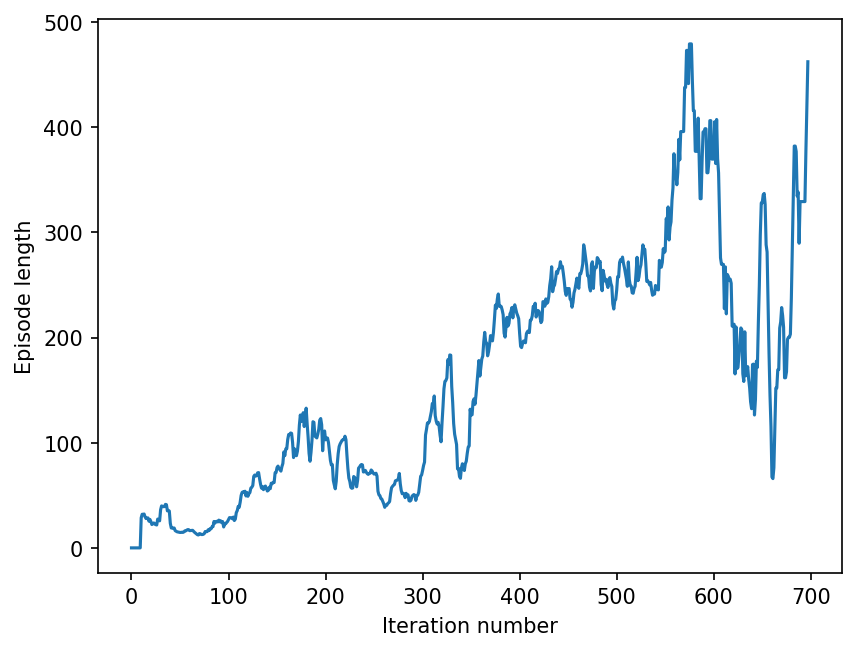

In [28]:
iters = np.arange(len(lengths))
plt.plot(iters, rolling_average(lengths, 10))
plt.xlabel("Iteration number")
plt.ylabel("Episode length")

In [33]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]
agent_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    ep_length = 0
    
    done = False
    
    while not done:
        _, _, _, _, done = agent.take_step(env)
        ep_length += 1
        if ep_length > 500:
            break
    
    agent_lengths.append(ep_length)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:00<00:00,  8.41s/it]


In [34]:
done = False

env = gym.make('CartPole-v1', render_mode='rgb_array')
random_lengths = []

for i in tqdm(range(100)):
    
    env.reset()
    
    done = False
    
    ep_length = 0
    
    while not done:
        action = np.random.randint(0, 2)
        _, _, done, _, _ = env.step(action)
        ep_length += 1
    
    random_lengths.append(ep_length)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 3033.99it/s]


In [35]:
np.mean(agent_lengths)

465.2

In [36]:
np.mean(random_lengths)

22.21

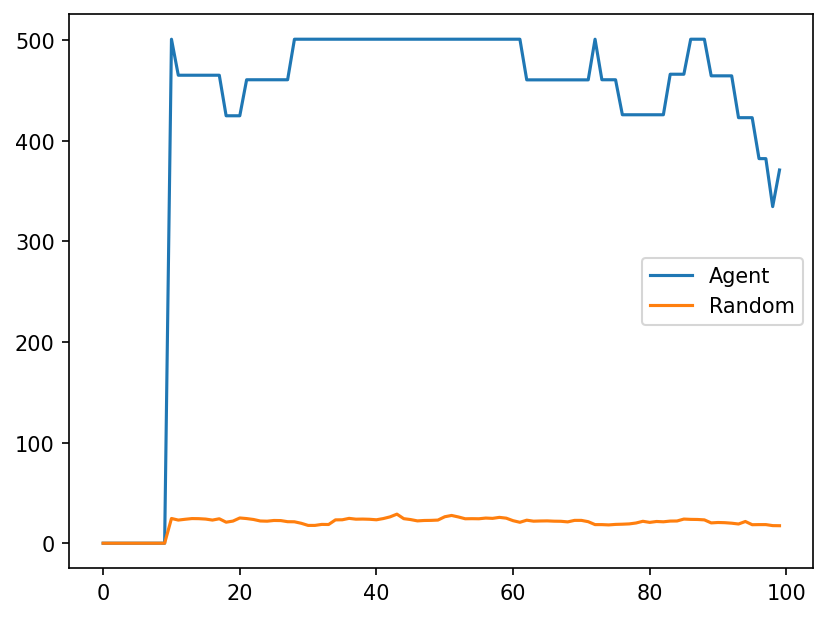

In [37]:
plt.plot(np.arange(100), rolling_average(agent_lengths, 10), label='Agent')
plt.plot(np.arange(100), rolling_average(random_lengths, 10 ), label='Random')
plt.legend()

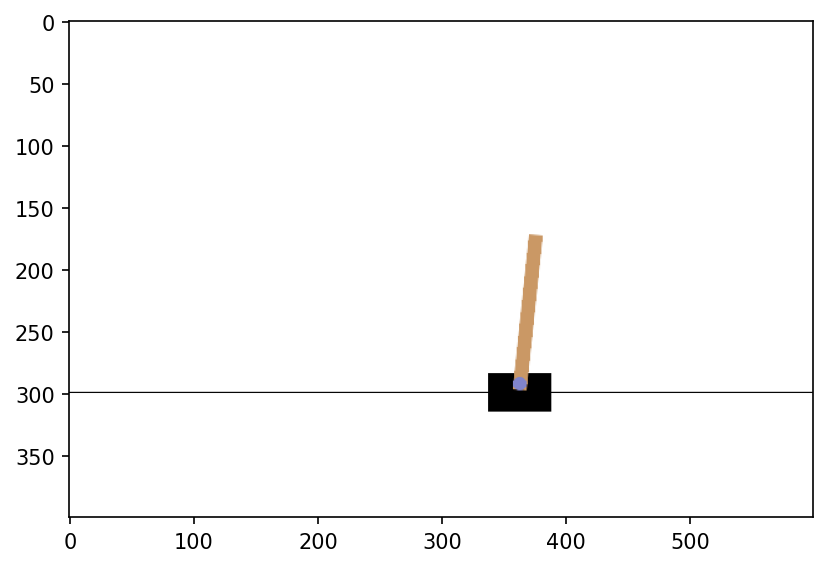

In [43]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
agent.state = env.reset()[0]

for i in range(50):
    plt.imshow(env.render())
    display.display(plt.gcf())    
    display.clear_output(wait=True)
    # env.step(env.action_space.sample()) # take a random action
    env.step(agent.find_action(agent.state))
    agent.state = np.array(env.state)
    
env.close()